# Getting the training data

In [1]:
import pandas as pd

In [2]:
sma_window_short = 20
sma_window_long = 80
num_batches = 1

In [3]:
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")

In [4]:
start = dt.datetime(2014, 9, 1)
end = dt.datetime.now()
df = web.DataReader('AAPL', 'iex', start, end)

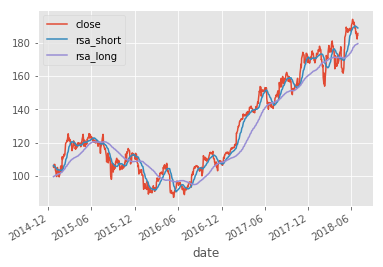

In [5]:
df = df[["close"]]
df["rsa_short"] = pd.Series.rolling(df["close"], window=sma_window_short).mean()
df["rsa_long"] = pd.Series.rolling(df["close"], window=sma_window_long).mean()
df.dropna(inplace=True)
df.index = pd.to_datetime(df.index)
df.plot()

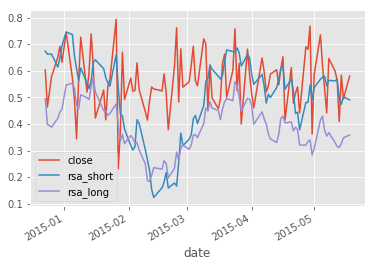

In [6]:
df = df - df.shift(-1)
df.dropna(inplace=True)
A=(df-df.min())/(df.max()-df.min())
A[:100].plot()

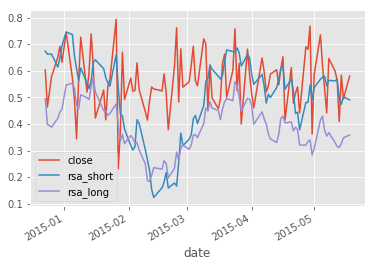

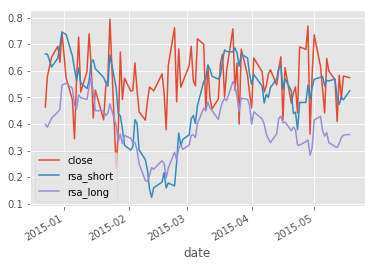

In [7]:
B=A.shift(-1)
A, B = A.dropna(), B.dropna()
A.drop(A.index[-1],inplace=True)
A[:100].plot()
plt.show()
B[:100].plot()
plt.show()

In [8]:
import numpy as np
A = A.values.reshape((A.shape[0], A.shape[1]))
B = B.values.reshape((B.shape[0], B.shape[1]))
A = np.array_split(A, num_batches)
B = np.array_split(B, num_batches)

# Model

In [9]:
import tensorflow as tf

In [10]:
lstm_size = 256
num_features = 3
learning_rate=0.05
layers = 5
iterations = 50
batch_size = 1

In [11]:
def rnn(size): 
    return tf.nn.rnn_cell.BasicRNNCell(size)
def multi(size, lay):
    return tf.nn.rnn_cell.MultiRNNCell([rnn(size) for _ in range(layers)])
with tf.name_scope("cell"):
    cell = multi(lstm_size, layers)
with tf.name_scope("output"):
    output = rnn(num_features)
X = tf.placeholder(tf.float32, [batch_size, None, num_features])
Y = tf.placeholder(tf.float32, [batch_size, None, num_features])
def run ():
    outputs1, state2 = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    outputs2, state2 = tf.nn.dynamic_rnn(output, outputs1, dtype=tf.float32)
    return outputs2
def compute_loss ():
    return tf.losses.mean_squared_error(Y, run())

# Training

Finished backward pass №0, loss: 0.12819573283195496, accuracy: 0.0
Finished backward pass №1, loss: 0.3396121561527252, accuracy: 0.0
Finished backward pass №2, loss: 0.4497438371181488, accuracy: 0.0
Finished backward pass №3, loss: 0.171798437833786, accuracy: 0.0
Finished backward pass №4, loss: 0.6564478278160095, accuracy: 0.0
Finished backward pass №5, loss: 0.24326986074447632, accuracy: 0.0
Finished backward pass №6, loss: 0.243269681930542, accuracy: 0.0
Finished backward pass №7, loss: 0.24326945841312408, accuracy: 0.0
Finished backward pass №8, loss: 0.24326926469802856, accuracy: 0.0
Finished backward pass №9, loss: 0.24326904118061066, accuracy: 0.0
Finished backward pass №10, loss: 0.24326880276203156, accuracy: 0.0
Finished backward pass №11, loss: 0.24326853454113007, accuracy: 0.0
Finished backward pass №12, loss: 0.24326825141906738, accuracy: 0.0
Finished backward pass №13, loss: 0.2432679980993271, accuracy: 0.0
Finished backward pass №14, loss: 0.2432677000761032

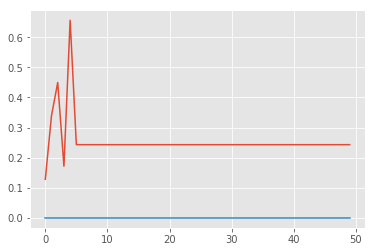

In [12]:
acc = tf.metrics.precision(Y, run())[0]
with tf.Session() as sess:
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(compute_loss())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    losses = []
    accuracies = []
    for i in range(iterations):
        np.random.shuffle(A)
        np.random.shuffle(B)
        a = A[:(batch_size or 1)]
        b = B[:(batch_size or 1)]
        sess.run(optimizer, feed_dict={X:a,Y:b})
        loss = sess.run(compute_loss(), feed_dict={X:a, Y:b})
        ac = sess.run(acc, feed_dict={X:a, Y: b})
        print("Finished backward pass №{}, loss: {}, accuracy: {}".format(i, loss, ac))
        losses.append(loss)
        accuracies.append(ac)
    plt.plot(losses)
    plt.plot(accuracies)
    # Ignore the accuracy

# Add a Keras model (I certainly did something wrong)...

In [13]:
from tensorflow.contrib import keras
Sequential = keras.models.Sequential
baseLSTM = keras.layers.LSTM
class LSTM(baseLSTM):
    def call(self, x, mask=None):
        if self.stateful: 
             self.reset_states()
        return super(LSTM, self).call(x, mask)

In [14]:
model = Sequential()
model.add(LSTM(lstm_size, return_sequences=True, go_backwards=True, batch_input_shape=(batch_size, None, num_features), stateful=True))
model.add(LSTM(num_features, return_sequences=True, go_backwards=True, stateful=True))

In [15]:
model.compile(loss="mean_squared_error", optimizer="rmsprop", metrics=["acc"])

In [16]:
A = np.asarray(A)
B = np.asarray(B)

In [17]:
history = model.fit(A, B, epochs=iterations)

ValueError: In a stateful network, you should only pass inputs with a number of samples that can be divided by the batch size. Found: 1 samples

In [18]:
#plt.plot(history.history["loss"])

# Alright, I'll change it...

In [19]:
model = Sequential()
model.add(LSTM(lstm_size, return_sequences=True, go_backwards=True, input_shape=(None, num_features), stateful=False))
model.add(LSTM(num_features, return_sequences=True, go_backwards=True, stateful=False))

In [20]:
model.compile(loss="mean_squared_error", optimizer="rmsprop", metrics=["acc"])

In [21]:
history = model.fit(A, B, epochs=iterations * 4)

Epoch 1/200
1/1 [==============================] - 31s 31s/step - loss: 0.3344 - acc: 0.2843
Epoch 2/200
1/1 [==============================] - 23s 23s/step - loss: 0.0851 - acc: 0.2412
Epoch 3/200
1/1 [==============================] - 24s 24s/step - loss: 0.0289 - acc: 0.2865
Epoch 4/200
1/1 [==============================] - 25s 25s/step - loss: 0.0290 - acc: 0.2412
Epoch 5/200
1/1 [==============================] - 16s 16s/step - loss: 0.0257 - acc: 0.4677
Epoch 6/200
1/1 [==============================] - 24s 24s/step - loss: 0.0259 - acc: 0.4700
Epoch 7/200
1/1 [==============================] - 25s 25s/step - loss: 0.0412 - acc: 0.4689
Epoch 8/200
1/1 [==============================] - 24s 24s/step - loss: 0.0237 - acc: 0.3545
Epoch 9/200
1/1 [==============================] - 24s 24s/step - loss: 0.0217 - acc: 0.5108
Epoch 10/200
1/1 [==============================] - 24s 24s/step - loss: 0.0202 - acc: 0.4700
Epoch 11/200
1/1 [==============================] - 25s 25s/step - lo

Epoch 89/200
1/1 [==============================] - 26s 26s/step - loss: 0.0139 - acc: 0.6512
Epoch 90/200
1/1 [==============================] - 26s 26s/step - loss: 0.0123 - acc: 0.7463
Epoch 91/200
1/1 [==============================] - 29s 29s/step - loss: 0.0106 - acc: 0.7724
Epoch 92/200
1/1 [==============================] - 27s 27s/step - loss: 0.0080 - acc: 0.7633
Epoch 93/200
1/1 [==============================] - 26s 26s/step - loss: 0.0073 - acc: 0.7837
Epoch 94/200
1/1 [==============================] - 26s 26s/step - loss: 0.0071 - acc: 0.7622
Epoch 95/200
1/1 [==============================] - 25s 25s/step - loss: 0.0078 - acc: 0.7769
Epoch 96/200
1/1 [==============================] - 24s 24s/step - loss: 0.0098 - acc: 0.6297
Epoch 97/200
1/1 [==============================] - 25s 25s/step - loss: 0.0131 - acc: 0.6444
Epoch 98/200
1/1 [==============================] - 25s 25s/step - loss: 0.0125 - acc: 0.6806
Epoch 99/200
1/1 [==============================] - 25s 25s/

Epoch 176/200
1/1 [==============================] - 23s 23s/step - loss: 0.0066 - acc: 0.7361
Epoch 177/200
1/1 [==============================] - 25s 25s/step - loss: 0.0066 - acc: 0.7610
Epoch 178/200
1/1 [==============================] - 24s 24s/step - loss: 0.0070 - acc: 0.7089
Epoch 179/200
1/1 [==============================] - 26s 26s/step - loss: 0.0074 - acc: 0.7656
Epoch 180/200
1/1 [==============================] - 28s 28s/step - loss: 0.0075 - acc: 0.7373
Epoch 181/200
1/1 [==============================] - 23s 23s/step - loss: 0.0092 - acc: 0.7407
Epoch 182/200
1/1 [==============================] - 24s 24s/step - loss: 0.0078 - acc: 0.7384
Epoch 183/200
1/1 [==============================] - 23s 23s/step - loss: 0.0061 - acc: 0.7701
Epoch 184/200
1/1 [==============================] - 26s 26s/step - loss: 0.0056 - acc: 0.8143
Epoch 185/200
1/1 [==============================] - 25s 25s/step - loss: 0.0058 - acc: 0.8029
Epoch 186/200
1/1 [==============================]

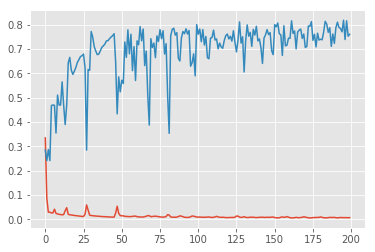

In [22]:
plt.plot(history.history["loss"])
plt.plot(history.history["acc"])

In [23]:
model.save("predictor3000.h5")

# Obviously,
the Keras model is better. I will use it for prediction.

In [24]:
def get_data(stock):
    start = dt.datetime(2014, 9, 1)
    end = dt.datetime.now()
    df = web.DataReader(stock, 'iex', start, end)
    df = df[["close"]]
    df["rsa_short"] = pd.Series.rolling(df["close"], window=sma_window_short).mean()
    df["rsa_long"] = pd.Series.rolling(df["close"], window=sma_window_long).mean()
    df.dropna(inplace=True)
    df.index = pd.to_datetime(df.index)
    df = df - df.shift(-1)
    df.dropna(inplace=True)
    A=(df-df.min())/(df.max()-df.min())
    B=A.shift(-1)
    A, B = A.dropna(), B.dropna()
    A.drop(A.index[-1],inplace=True)
    A = A.values.reshape((A.shape[0], A.shape[1]))
    B = B.values.reshape((B.shape[0], B.shape[1]))
    A = np.array_split(A, num_batches)
    B = np.array_split(B, num_batches)
    A = np.asarray(A)
    B = np.asarray(B)
    return A, B

In [25]:
tX, tY = get_data("TSLA")
score = model.evaluate(tX, tY)

1/1 [==============================] - 5s 5s/step


In [26]:
score[1]

0.6772366762161255

# Pretty high accuracy...
Let's add some Monte Carlo!

In [27]:
def evaluate(X, d, n=100, noise=0.05):
    '''Evaluates the training data with NOISE amount of noise and N Monte Carlo instances and returns the mean price direction after D days..'''
    Xs = np.asarray([X for i in range(n)])
    Xs = np.add(Xs, np.random.normal(size=Xs.shape, scale=noise))
    for i in range(d):
        Xs = model.predict(Xs)
    return np.mean(Xs[-1][0]) - X[0][0]

In [28]:
evaluate(tX[0], 2, 20)

-0.30506813792703436

# Time to make some MAAANNNAAAAYYY!!!

In [29]:
evaluate(get_data("USD")[0][:][0], 2, 20)

-0.03060242118541248

In [30]:
evaluate(get_data("NFLX")[0][:][0], 2, 20)

-0.31104803322866215

In [31]:
evaluate(get_data("AAPL")[0][:][0], 2, 20)

-0.44675981970008405

In [32]:
evaluate(get_data("ETH")[0][:][0], 2, 20)

-0.38592932857982176

In [33]:
evaluate(get_data("MSFT")[0][:][0], 2, 20)

-0.46338158741287305

In [34]:
evaluate(get_data("AMZN")[0][:][0], 2, 20)

-0.47333847984065736

In [35]:
evaluate(get_data("EBAY")[0][:][0], 2, 20)

-0.4910935365774236

In [36]:
evaluate(get_data("FB")[0][:][0], 2, 20)

-0.4170009162018036

# Wait...
Something is wrong here...

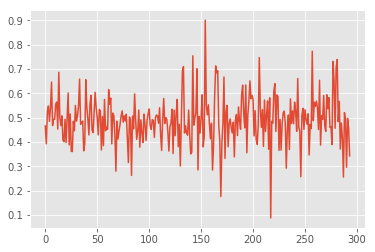

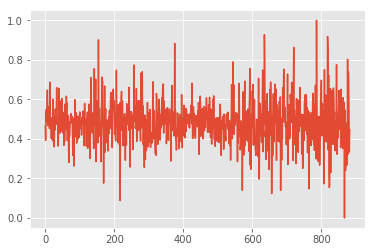

In [37]:
testX = tX[:,:len(tX[0])//3,:]
plt.plot(testX[0,:,0])
plt.show()
plt.plot(tX[0,:,0])
plt.show()

In [38]:
p = evaluate(testX[0], len(tX[0]) - len(testX[0]), 1, 0)

In [39]:
a = tX[0, -1, 0]

In [40]:
a, p

(0.44496044031647763, -0.4533888230678229)

# Okay, everything is fine...
But how do I convert this data to a real prediction?

In [41]:
def upeval(X, d, n=5, noise=.1):
    Xs = np.asarray([X for i in range(n)])
    Xs = np.add(Xs, np.random.normal(size=Xs.shape, scale=noise))
    for i in range(d):
        Xs = np.concatenate((Xs, model.predict(Xs)[:, -1, :].reshape(n, 1, Xs.shape[-1])), axis=1)
    return np.mean(Xs[:,-1,0], axis=0) - 0.5

In [42]:
upeval(get_data("MSFT")[0][0], 2, 10)

-0.07969037592411043

In [43]:
upeval(get_data("USD")[0][0], 2,10)

-0.1008703589439392

In [44]:
upeval(get_data("FB")[0][0], 2, 10)

-0.09957572817802429

In [45]:
upeval(get_data("TSLA")[0][0], 2, 10)

-0.0696914315223694

# Yup, that seems real.